<a href="https://colab.research.google.com/github/SGhuman123/Data-Science-Portfolio/blob/main/Udemy%20TensorFlow%20Developer%20Certificate%20Bootcamp/Section%2010%20Time%20Series%20Bitpredict%20Project/10_timeSeries_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 10. Time series fundamentals and Milestone Project 3: BitPredict 💰📈 Exercises

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
    * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
    * You can download the Bitcoin historical data for free from  [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin)  and clicking “Export Data” -> “CSV”.
3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?
    * Setup a series of experiments to find whether or not there’s a better window size.
    * For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for model_1 using  [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)  and retrain model_1 using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
    * Are there any other features you think you could add?
    * If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?


## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-05-18 10:02:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-05-18 10:02:21 (8.13 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with Pandas

In [ ]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date']) # parse the date column and tell pandas column 1 is a datetime

# Let's take a look at the data
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have?
len(df)

2787

In [ ]:
8 * 365

2920

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head(), bitcoin_prices.shape

(                Price
 Date                 
 2013-10-01  123.65499
 2013-10-02  125.45500
 2013-10-03  108.58483
 2013-10-04  118.67466
 2013-10-05  121.33866,
 (2787, 1))

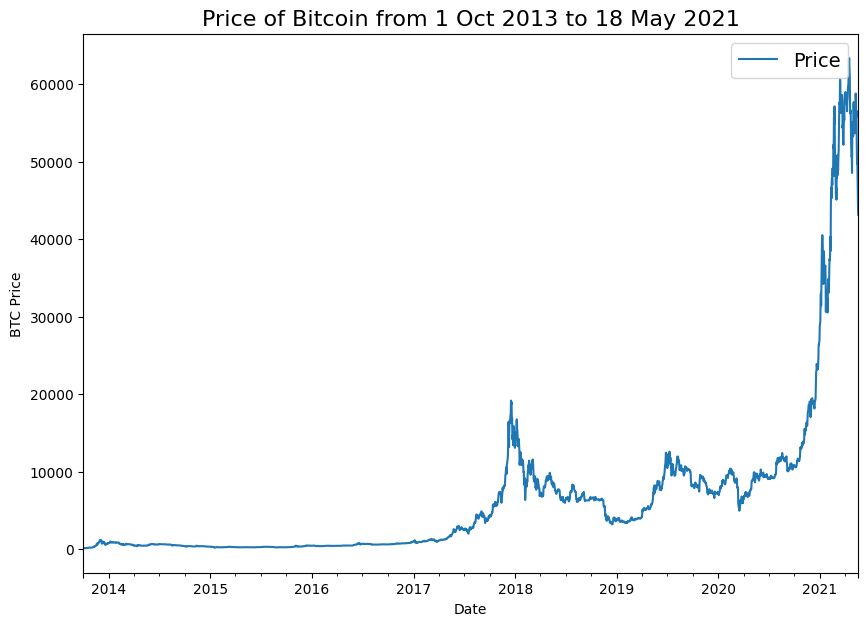

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [ ]:
# Get the data in array
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# Instantiating the sklearn MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [ ]:
# Create function to view NumPy arrays as windows

def get_labelled_windows(x , horizon):
  return x[:, :-horizon] ,x[: , -horizon:]


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applies the standard scaler
  """
  scaler.fit(np.expand_dims(x , axis =1))
  scaled_x = scaler.transform(np.expand_dims(x , axis = 1))
  scaled_x = np.squeeze(scaled_x)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)

* Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.


Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 1	Dense model, horizon =	1, window =	7
* 6	Same as 1 (but with multivariate data)

In [ ]:
# Model 1 (Horizon = 1 , Window_size = 7)
HORIZON = 1
WINDOW_SIZE = 7


full_windows , full_labels = make_windows_scaled(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
full_windows.shape , full_labels.shape

((2780, 7), (2780, 1))

In [ ]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [0.00023831 0.00026677 0.         0.00015955 0.00020168 0.00019087
 0.0002089 ] --> Label [0.00022847]
Window: [0.00026677 0.         0.00015955 0.00020168 0.00019087 0.0002089
 0.00022847] --> Label [0.00024454]
Window: [0.         0.00015955 0.00020168 0.00019087 0.0002089  0.00022847
 0.00024454] --> Label [0.00027478]


In [ ]:
# Making train and test splits
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
# Building the Model 1
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation= 'relu') ,
  layers.Dense(HORIZON , activation = 'linear')
])

# Compiling the model
model_1.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model_1.fit(x = train_windows ,
            y = train_labels ,
            epochs = 100 , batch_size = 128 , verbose = 0 ,
            validation_data = (test_windows , test_labels))

In [ ]:
# Evaluate the model on test data
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - mae: 0.0109


[0.010912558995187283, 0.010912558995187283]

In [ ]:
# Making predictions
model_1_preds = tf.squeeze(model_1.predict(test_windows))

18/18 [==============================] - 0s 2ms/step


Now doing the same for the Multivariate data especially for the Model 6



In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# Scaling the X data
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y , axis = 1))
y_scaled = np.squeeze(y_scaled)

In [ ]:
# Make train and test set splits of the scaled data
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Building a Multivariate time series model and fitting it
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128 , activation= 'relu'),
  layers.Dense(HORIZON)
])

model_6.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam())

model_6.fit(X_train , y_train ,
          epochs = 100 ,
          verbose = 0 , batch_size = 128,
          validation_data = (X_test , y_test))

In [ ]:
# Evaluate the model 6
model_6.evaluate(X_test , y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0742


0.0741642415523529


## 2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).

* You can download the Bitcoin historical data for free from [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin) and clicking "Export Data" -> "CSV".

In [ ]:
# Loading the in the latest csv from Coindesk
your_data_path = 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'
df_updated = pd.read_csv( your_data_path,
                 parse_dates = ['Date'] ,
                 index_col = ['Date'])

bitcoin_prices_updated = pd.DataFrame(df_updated["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices_updated.head(10) , bitcoin_prices_updated.shape

(                Price
 Date                 
 2013-10-01  123.65499
 2013-10-02  125.45500
 2013-10-03  108.58483
 2013-10-04  118.67466
 2013-10-05  121.33866
 2013-10-06  120.65533
 2013-10-07  121.79500
 2013-10-08  123.03300
 2013-10-09  124.04900
 2013-10-10  125.96116,
 (2787, 1))

In [ ]:
prices_updated = bitcoin_prices_updated['Price'].to_numpy()

In [ ]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows , full_labels = make_windows(prices_updated)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label [125.96116]


In [ ]:
# Making train and test splits
train_windows ,  test_windows ,train_labels,  test_labels =  make_train_test_splits(full_windows , full_labels)

len(train_windows) ,  len(test_windows) , len(train_labels),  len(test_labels)


(2224, 556, 2224, 556)

Now we're building the same Model 1 with the new coindesk data.



In [ ]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation= 'relu') ,
  layers.Dense(HORIZON , activation = 'linear')
])

# Compiling the model
model_1.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model_1.fit(x = train_windows ,
            y = train_labels ,
            epochs = 100 , batch_size = 128 , verbose = 0 ,
            validation_data = (test_windows , test_labels))

In [ ]:
# Evaluating the model
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 668.4493 - mae: 668.4493


[668.4493408203125, 668.4493408203125]

## 3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?

* Setup a series of experiments to find whether or not there's a better window size.
* For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [ ]:
# Writing a evaluation function based on the preds and targets
def evaluate_preds(y_true , y_pred):

  # Casting the values to float32
  y_true = tf.cast(y_true , tf.float32)
  y_pred = tf.cast(y_pred , tf.float32)


  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)

  # For longer horizons
  if mae.ndim > 0:
    mae = tf.reduce_sum(mae)
    mse = tf.reduce_sum(mse)
    rmse = tf.reduce_sum(rmse)
    mape = tf.reduce_sum(mape)

  return {'mae' : mae.numpy() ,
          'mse': mse.numpy() ,
          'rmse': rmse.numpy() ,
          'mape': mape.numpy() }

In [ ]:
# Writing a for loop to iterate over the Window size and build 10 different models

# 10 Different models with window size ranging from (2 - 12) and store the results
model_results_list = []

from tqdm import tqdm
for size in tqdm(range(2,12)):
  HORIZON = 1
  WINDOW_SIZE = size

  # Making window and labels
  full_windows , full_labels = make_windows(prices, window_size= WINDOW_SIZE , horizon= HORIZON)


  # Splitting the data in train and test
  train_windows ,  test_windows ,train_labels,  test_labels = make_train_test_splits(full_windows , full_labels)


  # Building a simple dense model
  input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer')
  x = layers.Dense(128 , activation= 'relu')(input)
  output = layers.Dense(HORIZON , activation= 'linear')(x)

  # Packing into a model
  model = tf.keras.Model(input , output , name = f'model_windowed_{size}')

  # Compiling and fitting the model
  model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model.fit(train_windows , train_labels ,
            epochs = 100 , verbose = 0 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_labels))


  # Making predictions
  preds_ = model.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  results = evaluate_preds(tf.squeeze(test_labels) , y_preds)
  model_results_list.append(results)


  0%|          | 0/10 [00:00<?, ?it/s]

18/18 [==============================] - 0s 2ms/step


 10%|█         | 1/10 [00:11<01:47, 11.91s/it]

18/18 [==============================] - 0s 4ms/step


 20%|██        | 2/10 [00:22<01:27, 10.96s/it]

18/18 [==============================] - 0s 2ms/step


 30%|███       | 3/10 [00:33<01:17, 11.04s/it]

18/18 [==============================] - 0s 2ms/step


 40%|████      | 4/10 [00:41<01:00, 10.02s/it]

18/18 [==============================] - 0s 2ms/step


 50%|█████     | 5/10 [00:51<00:49,  9.83s/it]

18/18 [==============================] - 0s 4ms/step


 60%|██████    | 6/10 [01:02<00:40, 10.19s/it]

18/18 [==============================] - 0s 2ms/step


 70%|███████   | 7/10 [01:13<00:31, 10.50s/it]

18/18 [==============================] - 0s 2ms/step


 80%|████████  | 8/10 [01:24<00:21, 10.60s/it]

18/18 [==============================] - 0s 2ms/step


 90%|█████████ | 9/10 [01:45<00:13, 13.97s/it]

18/18 [==============================] - 0s 2ms/step


100%|██████████| 10/10 [01:55<00:00, 11.54s/it]


In [ ]:
# Below are the 10 different models result
model_results_list

[{'mae': 571.52386, 'mse': 1160284.6, 'rmse': 1077.1652, 'mape': 2.5427465},
 {'mae': 565.8581, 'mse': 1149357.5, 'rmse': 1072.0809, 'mape': 2.5235336},
 {'mae': 603.01013, 'mse': 1216306.9, 'rmse': 1102.863, 'mape': 2.721311},
 {'mae': 567.7568, 'mse': 1171913.8, 'rmse': 1082.5497, 'mape': 2.5524468},
 {'mae': 663.079, 'mse': 1374877.2, 'rmse': 1172.5516, 'mape': 3.0954492},
 {'mae': 624.1076, 'mse': 1271802.0, 'rmse': 1127.742, 'mape': 2.8351088},
 {'mae': 631.3733, 'mse': 1306568.0, 'rmse': 1143.0521, 'mape': 2.9041865},
 {'mae': 600.7762, 'mse': 1225790.1, 'rmse': 1107.154, 'mape': 2.6990838},
 {'mae': 591.3246, 'mse': 1217991.9, 'rmse': 1103.6267, 'mape': 2.6804545},
 {'mae': 619.06506, 'mse': 1266054.8, 'rmse': 1125.1909, 'mape': 2.8171852}]

## 4. Create a windowed dataset just like the ones we used for `model_1` using [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

In [ ]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data = prices , targets = prices , sequence_length = WINDOW_SIZE , sequence_stride = HORIZON,
    batch_size = 128
)

In [ ]:
train_size , test_size = int(0.8 * len(ds)) ,int(0.2 * len(ds))

In [ ]:
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size).take(test_size)

In [ ]:
for x , y in train_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]], shape=(2, 7), dtype=float64) tf.Tensor([123.65499 125.455  ], shape=(2,), dtype=float64)


In [ ]:
for x , y in test_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[10302.19071368 10301.65965169 10231.42151196 10168.28770938
  10223.5055788  10138.33520522  9984.52051597]
 [10301.65965169 10231.42151196 10168.28770938 10223.5055788
  10138.33520522  9984.52051597 10031.86670899]], shape=(2, 7), dtype=float64) tf.Tensor([10302.19071368 10301.65965169], shape=(2,), dtype=float64)


In [ ]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Building a simple dense model
input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
x = layers.Dense(128 , activation= 'relu')(input)
output = layers.Dense(HORIZON , activation= 'linear')(x)

# Packing into a model
model = tf.keras.Model(input , output)

# Compiling the model
model.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model.fit(train_ds ,
          epochs = 100 , verbose = 0 ,
            validation_data = test_ds)

In [ ]:
# Evaluating the model on the test set
model.evaluate(test_ds)

4/4 [==============================] - 0s 14ms/step - loss: 451.4035 - mae: 451.4035


[451.4034729003906, 451.4034729003906]

## 5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
* Are there any other features you think you could add?
* If so, try it out, how do these affect the model?

In [ ]:
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [ ]:
import datetime

In [ ]:
# Creating a day of week feature
df['day_of_week'] = df.index.dayofweek
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),day_of_week
Date,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,1
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,2
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,3
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,4
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,5
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450,6
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199,0
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066,1
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266,2


In [ ]:
# Defining the hyper parameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [ ]:
# Getting three kinds of data (univariate , multivariate and the day of week)

# Univariate data
full_windows , full_labels = make_windows_scaled(prices)
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Multivaritate dat
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
X_scaled = scaler.fit_transform(X)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# Day of week
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [ ]:
# Checking the shapes
print(full_windows.shape , full_labels.shape)
print(X.shape , y.shape)
print(len(day_of_week))

(2780, 7) (2780, 1)
(2780, 9) (2780,)
2780


In [ ]:
# Splitting the multivariate and the day_of_week to train and test splits
split_size = int(len(X) * 0.8)
train_block_rewards , test_block_rewards = X[:split_size] , X[split_size:]
train_days , test_days = day_of_week[:split_size] , day_of_week[split_size:]

len(train_block_rewards), len(train_days) , len(test_block_rewards) , len(test_days)

(2224, 2224, 556, 556)

In [ ]:
# Building a performant dataset for train and test

train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows ,
                                                        train_block_rewards ,
                                                        train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# The test/val split
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows ,
                                                       test_block_rewards ,
                                                       test_days))

test_labels_tribid = tf.data.Dataset.from_tensor_slices(test_labels)

# Zipping the data and labels into one complete dataset
tribid_train_ds = tf.data.Dataset.zip((train_data_tribid , train_labels_tribid))
tribid_test_ds = tf.data.Dataset.zip((test_data_tribid , test_labels_tribid))

# Applying prefetch and batching the dataset
tribid_train_ds = tribid_train_ds.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_ds = tribid_test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_ds ,tribid_test_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [ ]:
# Building a tribid model

input_windows = layers.Input(shape = (7,) , dtype=tf.float64 , name='Window Inputs')
exp_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_windows)
conv1 = layers.Conv1D(filters= 32 , kernel_size=5 , padding='causal' , activation= 'relu')(exp_layer_1)
window_model = tf.keras.Model(input_windows , conv1 , name = 'Windowed model')

input_blocks = layers.Input(shape = (9,) , dtype= tf.float32 , name ='Block rewards input')
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_blocks)
conv2 = layers.Conv1D(filters = 32 , kernel_size= 5 , activation= 'relu' , padding = 'causal')(exp_layer_2)
block_model = tf.keras.Model(input_blocks , conv2 , name = 'Block rewards model')


# Use expand dims to match the same shape output (None , 1 , 128)
# whereas without expand dims it would be (None , 128)
input_days = layers.Input(shape= (1,) , dtype = tf.int32 , name ='Days of week Input')
exp_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_days)
dense = layers.Dense(128 , activation= 'relu')(exp_layer_3)
days_model = tf.keras.Model(input_days , dense , name = 'Days Model')

# Concatenating the inputs
concat = layers.Concatenate(name = 'combined_outputs' )([window_model.output ,
                                                           block_model.output ,
                                                           days_model.output])

# Creating the output layer
dropout = layers.Dropout(0.4)(concat)
output_layer = layers.Dense(1 , activation = 'linear')(dropout)

# Putting everything into a model
tribid_model = tf.keras.Model(inputs = [window_model.input ,
                                        block_model.input ,
                                        days_model.input] ,
                              outputs = output_layer)
tribid_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Window Inputs (InputLayer)  [(None, 7)]                  0         []                            
                                                                                                  
 Block rewards input (Input  [(None, 9)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 Days of week Input (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                            

In [ ]:
# Compiling and fitting the model
tribid_model.compile(loss = 'mae' ,
                     optimizer = 'adam' , metrics = ['mae'])

# Fitting the model
tribid_model.fit(tribid_train_ds ,
                 epochs = 20,
                 validation_data = tribid_test_ds , verbose = 2)

Epoch 1/20
18/18 - 5s - loss: 211.1350 - mae: 211.1350 - val_loss: 141.2473 - val_mae: 141.2473 - 5s/epoch - 255ms/step
Epoch 2/20
18/18 - 0s - loss: 149.3157 - mae: 149.3157 - val_loss: 158.4603 - val_mae: 158.4603 - 89ms/epoch - 5ms/step
Epoch 3/20
18/18 - 0s - loss: 99.5599 - mae: 99.5599 - val_loss: 114.7228 - val_mae: 114.7228 - 90ms/epoch - 5ms/step
Epoch 4/20
18/18 - 0s - loss: 63.8864 - mae: 63.8864 - val_loss: 90.9875 - val_mae: 90.9875 - 93ms/epoch - 5ms/step
Epoch 5/20
18/18 - 0s - loss: 37.3889 - mae: 37.3889 - val_loss: 83.5242 - val_mae: 83.5242 - 101ms/epoch - 6ms/step
Epoch 6/20
18/18 - 0s - loss: 16.4859 - mae: 16.4859 - val_loss: 26.5737 - val_mae: 26.5737 - 91ms/epoch - 5ms/step
Epoch 7/20
18/18 - 0s - loss: 4.8313 - mae: 4.8313 - val_loss: 5.7613 - val_mae: 5.7613 - 85ms/epoch - 5ms/step
Epoch 8/20
18/18 - 0s - loss: 1.2354 - mae: 1.2354 - val_loss: 3.4364 - val_mae: 3.4364 - 89ms/epoch - 5ms/step
Epoch 9/20
18/18 - 0s - loss: 0.4317 - mae: 0.4317 - val_loss: 0.5255

In [ ]:
# Evaluating the model
tribid_model.evaluate(tribid_test_ds)


5/5 [==============================] - 0s 6ms/step - loss: 0.0896 - mae: 0.0896


[0.0896495133638382, 0.0896495133638382]

## 6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.

**Things to do**

Train an ensemble model on the whole data.
Make one dataset (no test/valid) which will use to predict future forecasts of bitcoins.
Make a function that will take the number of iterations and different loss functions to train the model with.

In [ ]:
# Make one whole dataset (with the updated bitcoin prices 2014 - 2021)

X_all = bitcoin_prices_windowed.drop(['Price' , 'block_reward' , 'day_of_week'] , axis = 1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

whole_ds = tf.data.Dataset.from_tensor_slices((X_all , y_all))
whole_ds = whole_ds.batch(128).prefetch(tf.data.AUTOTUNE)
whole_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Creating the function

def get_ensemble_models(horizon = HORIZON ,
                        dataset = whole_ds ,
                        num_iter = 10 ,
                        num_epochs = 100 ,
                        loss_fns = ['mae' , 'mse' , 'mape']):


  # Make a empty list of the ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss functions
  for i in range(num_iter):
    for loss_functions in loss_fns:
      print(f'Optimizing model by reducing: {loss_functions} for {num_epochs} epochs, model number: {i}')

      model = tf.keras.Sequential([
          layers.Dense(128 , kernel_initializer='he_normal' , activation= 'relu'),
          layers.Dense(128 , kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(HORIZON)
      ])

      # Compiling the model
      model.compile(loss = loss_functions ,
                    optimizer = 'adam' , metrics = ['mae' , 'mse'])

      # Fit the model
      model.fit(dataset ,
                epochs = num_epochs ,
                verbose = 0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                                patience=100,
                                                                verbose=1)])

      ensemble_models.append(model)

  return ensemble_models

In [ ]:
# Running the above function
ensemble_models = get_ensemble_models(num_iter=5 , num_epochs= 1000 , horizon = 1)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 126: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 272: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 142: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 420: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 281: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 384: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 485: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 209: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 331: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

In [ ]:
# Making future forecastts of Bitcoins (using the whole data)
def make_future_forecast(values , model_list , into_future , window_size):

  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future):
    for model in model_list:

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]
  return future_forecast

In [ ]:
# Getting the future forecast
future_forecast = make_future_forecast(y_all , ensemble_models , into_future= 14 , window_size = 7 )

1/1 [==============================] - 0s 46ms/step
Predicing on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 56297.62109375

1/1 [==============================] - 0s 45ms/step
Predicing on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56297.62109375] --> Prediction: 50219.31640625

1/1 [==============================] - 0s 44ms/step
Predicing on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56297.62109375 50219.31640625] --> Prediction: 49141.48046875



1/1 [==============================] - 0s 52ms/step
Predicing on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56297.62109375 50219.31640625 49141.48046875] --> Prediction: 51127.80078125



1/1 [==============================] - 0s 50ms/step
Predicing on: 
 [47885.62525472 45604.61575361 43144.47129086 56297.62109375
 50219.31640625 49141.48046875 51127.80078125] --> Prediction: 48082.484375

1/1 [==============================] - 0s 48ms/step
Predicing on: 
 [45604.61575361 43144.47129086 56297.62109375 50219.31640625
 49141.48046875 51127.80078125 48082.484375  ] --> Prediction: 45861.625

1/1 [==============================] - 0s 50ms/step
Predicing on: 
 [43144.47129086 56297.62109375 50219.31640625 49141.48046875
 51127.80078125 48082.484375   45861.625     ] --> Prediction: 46296.75390625

1/1 [==============================] - 0s 47ms/step
Predicing on: 
 [56297.62109375 50219.31640625 49141.48046875 51127.80078125
 48082.484375   45861.625      46296.75390625] --> Prediction: 56098.21875

1/1 [==============================] - 0s 53ms/step
Predicing on: 
 [50219.31640625 49141.48046875 51127.80078125 48082.484375
 45861.625      46296.75390625 56098.21875   ] --> 

## 7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?

- append pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)
- #7 is train a new model every single time a pred is made


In [ ]:
# Lets code things at first without a loop and see how it foes
HORIZON = 1
WINDOW_SIZE = 7

# Building a model (You can replace it with any model)
def get_model(horizon = HORIZON):
    model = tf.keras.Sequential([
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(horizon)
        ])

    model.compile(loss = tf.keras.losses.mae ,
                  optimizer = tf.keras.optimizers.Adam())


    return model

In [ ]:
#. Making the data and labels for window size of 7 and horizon of 1
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon= HORIZON)

In [ ]:

# Making future forecastts of Bitcoins (using the whole data)
def pred_model_run(values , X, model , into_future , window_size  , horizon, epochs ):

  '''
  This function train a model for every updated predictions.

  Arguments:
  ----------
      - values --> labels / truth values. Bitcoin prices
      - X --> Windowed data of the bitcoin prices (default window size is 7)
      - model --> compiled model with default horizon 1
      - into_future -->  how many time steps to predict in the future?
      - window_size --> default is 7 (using the 7 days prices of bitcoin)
      - horizon --> default is 1 (predicting the price of next day)

  Returns:
  --------
      - model --> a model that has been trained on all the previous predictions + the data
  '''

  last_window = values[-window_size:]
  X_all = X
  y_all = values
  for _ in range(into_future):

      # Each time the model is trained for 5 epochs with the updated data
      model.fit(x = X_all , y = y_all , epochs = epochs , verbose = 0)

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())
      #values = np.append(values , tf.squeeze(future_pred).numpy())
      for i in range(0 , len(X_all)):
        x = X_all[i][1:]  # removing the 0th index of the X window ()
        y = y_all[1:] # removing the 0th index  of y
        X = np.append(x , future_pred) # append the future pred at last to X window
        values = np.append(y , future_pred) # appending the future pred to y

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]


  return model

In [ ]:
full_windows.shape , X_all.shape , full_labels.shape , y_all.shape

((2780, 7), (2780, 7), (2780, 1), (2780,))

In [ ]:
# Using the above function
trained_model = pred_model_run(values = tf.squeeze(full_labels) ,
                               X = full_windows ,
                               model = get_model(horizon = 1) ,
                               window_size = WINDOW_SIZE ,
                               horizon = HORIZON ,
                               epochs = 10 ,
                               into_future  =14 )

1/1 [==============================] - 0s 54ms/step
Predicing on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 43466.8046875

1/1 [==============================] - 0s 19ms/step
Predicing on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 43466.8046875 ] --> Prediction: 43002.4921875

1/1 [==============================] - 0s 18ms/step
Predicing on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 43466.8046875  43002.4921875 ] --> Prediction: 42684.63671875

1/1 [==============================] - 0s 16ms/step
Predicing on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 43466.8046875  43002.4921875  42684.63671875] --> Prediction: 41233.39453125

1/1 [==============================] - 0s 21ms/step
Predicing on: 
 [47885.62525472 45604.61575361 43144.47129086 43466.8046875
 43002.4921875  42684.63671875 41233.39453